In [1]:
import torch
import os
import json
import numpy as np
import pickle

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt 

In [2]:
parent_path = "../neurips/"
approach = "abstractbeam"
os.getcwd()
os.listdir(parent_path + "abstractbeam/models")

['model-best-valid.ckpt', 'logs', 'model-latest.ckpt']

In [13]:
with open(parent_path + f"{approach}/models2/model-latest.ckpt", "rb") as f:
    ckpt = torch.load(f)  # , map_location=torch.device("mps"))

In [14]:
ckpt['domain'].operations

[Add,
 Subtract,
 Multiply,
 IntDivide,
 Square,
 Min,
 Max,
 Greater,
 Less,
 Equal,
 IsEven,
 IsOdd,
 If,
 Head,
 Last,
 Take,
 Drop,
 Access,
 Minimum,
 Maximum,
 Reverse,
 Sort,
 Sum,
 Map,
 Filter,
 Count,
 ZipWith,
 Scanl1,
 fn_1,
 fn_3,
 fn_5]

In [15]:
for op in ckpt['domain'].operations:
    found = False
    for file in os.listdir(parent_path + f"{approach}/data2/"):
        with open(parent_path + f"{approach}/data2/" + file, "rb") as f:
            train_data = pickle.load(f)
            filter = [ele.solution.expression() for ele in train_data if str(op) in ele.solution.expression()]
            if len(filter) > 1:
                print(f"Found {op}")
                found = True
                break
    if not found:
        print(f"Not Found: {op}")

Found Add
Found Subtract
Found Multiply
Found IntDivide
Found Square
Found Min
Found Max
Found Greater
Found Less
Found Equal
Found IsEven
Found IsOdd
Found If
Found Head
Found Last
Found Take
Found Drop
Found Access
Found Minimum
Found Maximum
Found Reverse
Found Sort
Found Sum
Found Map
Found Filter
Found Count
Found ZipWith
Found Scanl1
Not Found: fn_1
Not Found: fn_3
Not Found: fn_5


In [6]:
for key in ckpt.keys():
    print(key)

step
model
optimizer
inventions
higher_order_functions
base_function_dict
dc_abstractions
domain
frontiers


In [7]:
ckpt["higher_order_functions"]

{'Map': [1, 0],
 'Filter': [1, 0],
 'Count': [1, 0],
 'ZipWith': [2, 0, 0],
 'Scanl1': [2, 0],
 'fn_2': [1, 0],
 'fn_5': [1, 0],
 'fn_7': [2, 1, 0],
 'fn_9': [2, 0]}

In [8]:
inventions = ckpt["inventions"]
for inv in inventions:
    print(inv.name, inv.program)

fn_2 x1(Take(-1, x2))
fn_5 x1(Min(0, x2))
fn_7 x2((lambda v1: x1(Min(0, v1))), x3)
fn_9 Count((lambda v1: x1(v1, 0)), x2)


In [9]:
ckpt['domain'].operations[-3].apply_single([lambda x: x > 1, 2])

TypeError: <lambda>() got multiple values for argument 'op'

In [16]:
constants = ckpt["domain"].constants
print(f"initial constants: {[-1, 1]}")
print(f"now: {constants}")

initial constants: [-1, 1]
now: [-1, 1, 0]


In [17]:
with open(parent_path + "abstractbeam/results/run_1.json", "rb") as json_file:
    results = json.load(json_file)
solutions = [ele for ele in results["results"] if ele["success"]]
len(solutions) / len(results["results"]) * 100, len(ckpt['frontiers']) / len(results["results"]) * 100

(38.0, 36.0)

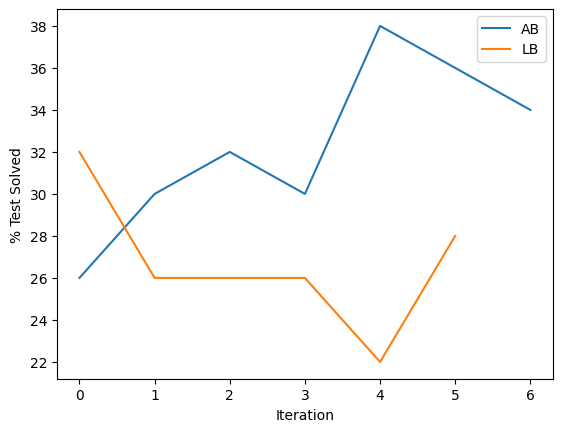

In [18]:
# Path to your event file or directory
ab_file = parent_path + 'abstractbeam/models/logs/events.out.tfevents.1713457154.dws-07.1432984.0'
lb_file = parent_path + 'lambdabeam/models/logs/events.out.tfevents.1713532162.dws-06.528186.0'

# Initialize an event accumulator
event_AB = EventAccumulator(ab_file)
event_LB = EventAccumulator(lb_file)
event_AB.Reload()
event_LB.Reload()

scalars_AB = event_AB.Scalars('eval/succ')
scalars_LB = event_LB.Scalars('eval/succ')

plt.plot(np.array([ele.value for ele in scalars_AB]) * 100, label="AB")
plt.plot(np.array([ele.value for ele in scalars_LB]) * 100, label="LB")
plt.ylabel("% Test Solved")
plt.xlabel("Iteration")
plt.legend()

In [ ]:
np.diff([ele.wall_time for ele in scalars_AB]) / 3600, np.diff([ele.wall_time for ele in scalars_LB]) / 3600

In [ ]:
programs = [ele["solution"] for ele in solutions]
for op in ckpt['domain'].operations:
    found = False
    for p in programs:
        if str(op) in p:
            print(f"Found {op}: {p}")
            found = True
            break
    if not found:
        print(f"Not Found: {op}.")
            

In [19]:
[ele["solution"] for ele in solutions] #  if "fn" in ele["solution"] or "0" in ele["solution"]]

['Sort(Map((lambda u1: ((lambda v1: Square(v1)))(u1)), x))',
 'Multiply(k, Add(1, IntDivide(x, k)))',
 'Map((lambda u1: ((lambda v1: Subtract(((lambda v1: Square(v1)))(v1), v1)))(u1)), x)',
 'Reverse(Drop(Multiply(k, -1), Sort(x)))',
 'Drop(1, Take(-1, x))',
 'Scanl1((lambda u1, u2: ((lambda v1: Access(v1, x)))(u1)), x)',
 'fn_9((lambda u1, u2: ((lambda v1: Greater(0, v1)))(u1)), x)',
 'Filter((lambda u1: ((lambda v1: IsOdd(((lambda v1: Min(0, v1)))(v1))))(u1)), x)',
 'Sort(ZipWith((lambda u1, u2: ((lambda v1, v2: IntDivide(v1, v2)))(u1, u2)), m, n))',
 'Scanl1((lambda u1, u2: ((lambda v1, v2: Max(v1, v2)))(u2, u1)), x)',
 'Sort(Filter((lambda u1: ((lambda v1: IsEven(v1)))(u1)), x))',
 'fn_9((lambda u1, u2: ((lambda v1: fn_5((lambda u1: ((lambda v1: IsEven(v1)))(u1)), v1)))(u1)), x)',
 'Map((lambda u1: ((lambda v1: If(((lambda v1: Less(1, v1)))(v1), v1, y)))(u1)), x)',
 'Scanl1((lambda u1, u2: ((lambda v1: Add(v1, 1)))(u1)), Map((lambda u1: 0), x))',
 'Take(Count((lambda u1: ((lambda v

In [ ]:
categories = {}
for result in solutions:
    category = result['task'].split("name=")[1].split(":")[0]
    if category[1:] in categories.keys():
        categories[category[1:]] += 1
    else:
        categories[category[1:]] = 1

In [ ]:
categories

In [ ]:
t = [ele[0][0] for ele in ckpt['frontiers'].values() if  " 0" in ele[0][0] or " -1" in ele[0][0] or " 1"]

In [ ]:
sols = [ele["solution"] for ele in solutions]
res = [ele[0][0] for ele in ckpt["frontiers"].values()]


In [ ]:
solution_programs = [(ele["solution"], ele["task_solution"]) for ele in solutions]

In [ ]:
s = [ele["task"].split("solution=")[1][1:-3] for ele in results["results"]]

In [ ]:
print("Number of programs containing a constant value")
for i in range(-1, 5):
    filtered = [ele for ele in s if f" {i}" in ele]
    print(f"{i}: {len(filtered)}")

In [ ]:
print("Average length of programs containing a constant value")
for i in range(-1, 5):
    filtered = [len(ele.split(" ")) for ele in s if f" {i}" in ele]
    print(f"{i}: {np.mean(filtered)}")

In [ ]:
for i in range(-1, 5):
    filtered = [ele for ele in s if f" {i}" in ele]
    print(f"{i}: {filtered}")